# Análise de sentimento usando LSTM - na Base de filmes IMDB

## Introdução

Este notebook contém o mesmo exemplo de predição do sentimento das avaliações de filmes já feito anteriormente
utilizando rede convolucional e max-pooling.

A solução adotada neste notebook utiliza a rede recorrente LSTM para ilustrar a forma de utilizá-la em 
um problema real.

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, l1
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import get_file
from keras.datasets import imdb

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


In [2]:
import keras.backend as K
# K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())
!nvidia-smi

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']
Mon Jun 26 18:21:51 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.51                 Driver Version: 375.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   49C    P0    38W / 149W |  10873MiB / 11439MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Pr

## Funções de apoio ao treinamento

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura do Dataset IMDB

O Keras já possui este dataset para leitura. Ele é composto de 25 mil amostras de treinamento e 25 mil amostras de teste.
Cada amostra possui um texto de tamanho que varia entre 11 e 2494 palavras. Cada amostra tem um rótulo
associado com 1 para denominar sentimento positivo e 0 para sentimento negativo.

### Leitura dos textos de revisão e rótulos dos sentimentos

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)


### Leitura dos índices das palavras

In [5]:
from keras.datasets import imdb
idx = imdb.get_word_index()

## Preparando o dataset

Existe dois ajustes necessários do dataset antes de colocá-lo na rede neural:
1. Tornar os textos de cada amostra com mesmo comprimento
2. Limitar o vocabulário 

### Fazendo textos ficarem com mesmo comprimento - truncar ou completar

Observa-se que o comprimento mínimo de palavras é 11, o máximo é 2494 e o valor médio é 238.
Assim, iremos utilizar um comprimento padrão de 500 palavras.

In [6]:
lens = np.array(list(map(len, x_train)))
(lens.min(), lens.max(), lens.mean())

(11, 2494, 238.71364)

A função `pad_sequences` do Keras trunca o texto em 150 palavras e caso o texto tenha
um número menor de palavras, ele é completado com os valores zero.
Foi feito um rápido *grid-search* para encontrar o melhor comprimento da sequência.

In [7]:
SEQ_LEN = 150

x_train_pad = sequence.pad_sequences(x_train, maxlen=SEQ_LEN+1, value=0,
                                     padding='post', 
                                     truncating='post')[:,1:] # eliminando primeiro código: 1
x_test_pad  = sequence.pad_sequences(x_test,  maxlen=SEQ_LEN+1, value=0, 
                                     padding='post', 
                                     truncating='post')[:,1:] # eliminando primeiro código: 1

In [8]:
print(x_train_pad.shape)

(25000, 150)


### Limitando o vocabulário de 88.584 para 20 mil palavras mais utilizadas

Existe muitas palavras de pouco uso que muitas vezes podem tornar a análise mais difícil.
É comum, portanto limitar o vocabulário, convertendo o código das palavras fora do vocabulário
como o último código.

In [9]:
VOCAB_SIZE = 20000

x_train_clip = np.clip(x_train_pad,0,VOCAB_SIZE-1)
x_test_clip  = np.clip(x_test_pad, 0,VOCAB_SIZE-1)

Um artigo de 2011 [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) relata um acurácia de 88,3%.

O exemplo feito anteriormente com rede convolucional e max-pooling com sequência de 500 palavras possui uma acurácia de 88,69%.

## Rede Recorrente LSTM

Utiliza-se uma rede LSTM com os seguintes parâmetros:
- LSTM com 128 neurônios;
- embedding com 20 mil palavras e 128 features;
- sequência de 150 palavras;

Foram necessários várias regularizações: 
- regularização L2 do embedding,
- dropout do embedding de 0.2
- batch normalization após o embedding
- LSTM com dropout do kernel de 0.35 e o dropout recorrente de 0.2

Com isto conseguiu-se uma acurácia de 83% após 3 épocas de treinamento.

### Definindo o modelo

In [10]:
rnn1 = Sequential()
rnn1.add(Embedding(VOCAB_SIZE, 128, 
                   embeddings_regularizer=l2(1e-4),
                   input_length=SEQ_LEN))
rnn1.add(keras.layers.SpatialDropout1D(0.2))
rnn1.add(BatchNormalization())
rnn1.add(LSTM(128, dropout=0.35, recurrent_dropout=0.2))
rnn1.add(Dense(1, activation='sigmoid'))

rnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 128)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 128)          512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,692,225
Trainable params: 2,691,969
Non-trainable params: 256
_________________________________________________________________


### Treinando

Este treinamento está demorando um pouco mais de 3 minutos por época, na GPU K80

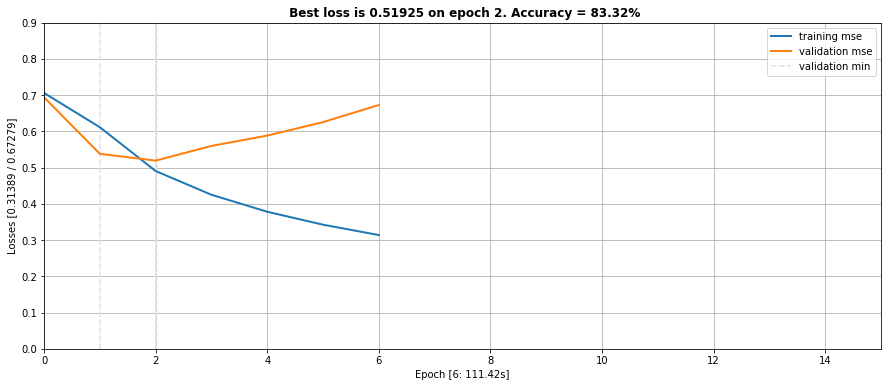

In [11]:
model_name = '../../models/AS_IMDB_rnn1'
fit_params = {
    'model_name': model_name,
    'loss': 'binary_crossentropy',
    'opt':        Adam(),   
    'batch_size': 32, 
    'nepochs':    15,
    'patience':   5,
    'ploss':      0.9,
    'reset':      True,
}

train_network(rnn1, x_train_clip, y_train, x_test_clip, y_test, **fit_params);


### Avaliação da rede

In [12]:
test_network(model_name, x_test_clip, y_test)

Model from epoch 2
[INFO] evaluating in the test data set ...
24960/25000 [============================>.] - ETA: 0s 

## Aprendizados

- 